In [17]:
# ===== 00. Imports =====
import os
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120


In [18]:
# ===== 01. Config =====
DATA_PATH_CSV = "vessels.csv"          # pas aan
PARQUET_DIR   = "vessels_parquet"      # wordt aangemaakt bij conversie
CHUNK_ROWS    = 2_000_000              # voor CSV->Parquet
USE_PARQUET   = True                   # sneller en zuiniger
SAMPLE_FRAC_TUNE = 0.10                # 10% sample voor snelle tuning/ sanity check

# XGBoost basisparams (grote cap; early stopping kiest optimum)
xgb_params = dict(
    objective="reg:squarederror",
    tree_method="hist",          # zet op "gpu_hist" als CUDA beschikbaar is
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=1e-4,
    n_estimators=10_000,         # cap, wordt eerder gestopt
    n_jobs=-1,
    random_state=42
)
EARLY_STOP_ROUNDS = 100
VERBOSE_EVERY = 25               # print elke N boosting rounds


In [19]:
PATH_VESSEL = r"C:\Users\Wesse\OneDrive\Documents\WESSEL SCHOOL\Master\TIL Python Programming\TIL6022-group-project\OneDrive_1_27-10-2025\Vesselposition_data_20-24Aug2025.csv"
PATH_WEATHER = r"SAIL_Amsterdam_10min_Weather_2025-08-20_to_2025-08-24.csv"
PATH_SENSORS_LOC = r"sensor-location.xlsx - Sheet1.csv"
PATH_SENSORS = r"sensordata_SAIL2025.csv"

# vessels: rename + drop + parse
vessels = (
    pd.read_csv(PATH_VESSEL, low_memory=False)
      .rename(columns={"upload-timestamp": "timestamp"})
      .drop(columns=[c for c in ["stale_since"] if c in pd.read_csv(PATH_VESSEL, nrows=0).columns])
)
if "timestamp" in vessels.columns:
    vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], errors="coerce")

# weather: parse timestamp als aanwezig
weather = pd.read_csv(PATH_WEATHER, low_memory=False)
for c in weather.columns:
    if "time" in c.lower():
        weather[c] = pd.to_datetime(weather[c], errors="coerce")
        if c != "timestamp" and "timestamp" not in weather.columns:
            weather = weather.rename(columns={c: "timestamp"})
        break

# sensor locaties
sensors_location = (
    pd.read_csv(PATH_SENSORS_LOC, low_memory=False)
      .rename(columns={"Objectnummer": "sensor_id"})
)

# sensordata
sensors = pd.read_csv(PATH_SENSORS, parse_dates=["timestamp"], low_memory=False)

# optioneel: downcast numeriek om RAM te sparen
def _downcast_numeric(df):
    for c in df.select_dtypes(include=["float64","int64"]).columns:
        df[c] = pd.to_numeric(df[c], errors="coerce", downcast="float")
    return df

vessels = _downcast_numeric(vessels)
weather = _downcast_numeric(weather)
sensors = _downcast_numeric(sensors)

print(
    "Loaded",
    f"vessels={vessels.shape}",
    f"weather={weather.shape}",
    f"sensors={sensors.shape}",
    f"sensors_location={sensors_location.shape}",
)

Loaded vessels=(12641979, 32) weather=(714, 4) sensors=(2400, 81) sensors_location=(36, 5)


In [28]:
# ===== 02. Data inlezen =====
# Scenario A: bestaande variabelen uit je Ridge-notebook
if "agg_df" in globals() and "target_cols" in globals() and "split_time" in globals():
    feature_cols = [c for c in agg_df.columns if c not in target_cols and c not in ("timestamp",)]
    feature_names = feature_cols

    train_mask = agg_df["timestamp"] < split_time
    test_mask  = ~train_mask

    X_train = agg_df.loc[train_mask, feature_cols].astype("float32").values
    y_train = agg_df.loc[train_mask, target_cols].astype("float32").values
    X_test  = agg_df.loc[test_mask,  feature_cols].astype("float32").values
    y_test  = agg_df.loc[test_mask,  target_cols].astype("float32").values

else:
    # Scenario B: zelfstandig inlezen. Vul feature_cols en target_cols in.
    assert "feature_cols" in globals() and "target_cols" in globals(), "Definieer feature_cols en target_cols."
    feature_names = feature_cols

    if USE_PARQUET and os.path.isdir(PARQUET_DIR):
        files = sorted([os.path.join(PARQUET_DIR, f) for f in os.listdir(PARQUET_DIR) if f.endswith(".parquet")])
        df = pd.concat([pd.read_parquet(p) for p in files], ignore_index=True)
    elif USE_PARQUET and not os.path.isdir(PARQUET_DIR):
        os.makedirs(PARQUET_DIR, exist_ok=True)
        parts = []
        for i, ch in enumerate(pd.read_csv(DATA_PATH_CSV, chunksize=CHUNK_ROWS)):
            # hou alleen relevante kolommen
            keep = ["timestamp"] + feature_cols + target_cols
            ch = ch[[c for c in keep if c in ch.columns]].copy()
            # parse types
            if "timestamp" in ch.columns:
                ch["timestamp"] = pd.to_datetime(ch["timestamp"], errors="coerce")
            for c in ch.columns:
                if c != "timestamp":
                    ch[c] = pd.to_numeric(ch[c], errors="coerce").astype("float32")
            p = os.path.join(PARQUET_DIR, f"part_{i:03d}.parquet")
            ch.to_parquet(p, index=False); parts.append(p)
        df = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
    else:
        df = pd.read_csv(DATA_PATH_CSV)
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
        for c in feature_cols + target_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")

    # tijdgebaseerde split verplicht
    assert "split_time" in globals(), "Definieer split_time voor tijdgebaseerde train/test split."
    train_mask = df["timestamp"] < split_time
    test_mask  = ~train_mask

    X_train = df.loc[train_mask, feature_cols].astype("float32").values
    y_train = df.loc[train_mask, target_cols].astype("float32").values
    X_test  = df.loc[test_mask,  feature_cols].astype("float32").values
    y_test  = df.loc[test_mask,  target_cols].astype("float32").values


In [29]:
# ===== 03. Optionele snelle tuning op subsample (werkt ook als sanity check) =====
# Gebruik klein deel data om max_depth en regularisatie grof te kiezen.
# Je kunt overslaan door SKIP_TUNE=True te zetten.
SKIP_TUNE = False

if not SKIP_TUNE:
    rs = np.random.RandomState(42)
    idx = rs.choice(len(X_train), size=int(len(X_train)*SAMPLE_FRAC_TUNE), replace=False)
    Xs, ys = X_train[idx], y_train[idx]

    # neem eerste target als proxy voor tuning
    y0 = ys[:, 0]
    X_tr, X_va, y_tr, y_va = train_test_split(Xs, y0, test_size=0.2, random_state=42)

    grid = [
        dict(max_depth=4, reg_lambda=1.0, reg_alpha=1e-4),
        dict(max_depth=6, reg_lambda=1.0, reg_alpha=1e-4),
        dict(max_depth=6, reg_lambda=3.0, reg_alpha=1e-3),
        dict(max_depth=8, reg_lambda=3.0, reg_alpha=1e-3),
    ]

    xgb_params.update(dict(eval_metric="rmse"))

    best = None
    best = None
    for g in grid:
        p = dict(xgb_params, **g)
        p.pop("eval_metric", None); p.pop("early_stopping_rounds", None)
        p.setdefault("eval_metric", "rmse")
        p.setdefault("early_stopping_rounds", EARLY_STOP_ROUNDS)

        m = XGBRegressor(**p).fit(
            X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=VERBOSE_EVERY
        )
        rmse = m.evals_result()["validation_1"]["rmse"][m.best_iteration]
        if best is None or rmse < best[0]:
            best = (rmse, g)


    print("Chosen params from sample:", best[1])
    xgb_params.update(best[1])


[0]	validation_0-rmse:1.38707	validation_1-rmse:1.51582
[25]	validation_0-rmse:0.57122	validation_1-rmse:0.88185
[50]	validation_0-rmse:0.30675	validation_1-rmse:0.71470
[75]	validation_0-rmse:0.20796	validation_1-rmse:0.66089
[100]	validation_0-rmse:0.14990	validation_1-rmse:0.63647
[125]	validation_0-rmse:0.11582	validation_1-rmse:0.61965
[150]	validation_0-rmse:0.09060	validation_1-rmse:0.60667
[175]	validation_0-rmse:0.07443	validation_1-rmse:0.60068
[200]	validation_0-rmse:0.05948	validation_1-rmse:0.59976
[225]	validation_0-rmse:0.04903	validation_1-rmse:0.59799
[250]	validation_0-rmse:0.04074	validation_1-rmse:0.59727
[275]	validation_0-rmse:0.03344	validation_1-rmse:0.59728
[300]	validation_0-rmse:0.02747	validation_1-rmse:0.59714
[325]	validation_0-rmse:0.02370	validation_1-rmse:0.59705
[350]	validation_0-rmse:0.02001	validation_1-rmse:0.59625
[375]	validation_0-rmse:0.01705	validation_1-rmse:0.59658
[400]	validation_0-rmse:0.01467	validation_1-rmse:0.59682
[425]	validation_0-

In [30]:
# ===== 04. Definitieve train/valid split =====
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [32]:
# ===== 05. Train per target met early stopping + epoch logging =====
models = {}
logs = {}

# maak schone params en zet defaults één keer
params = dict(xgb_params)          # kopie
params.pop("eval_metric", None)    # dubbele verwijderen
params.pop("early_stopping_rounds", None)
params.setdefault("eval_metric", "rmse")
params.setdefault("early_stopping_rounds", EARLY_STOP_ROUNDS)

for ti, t in enumerate(target_cols):
    print(f"\n===== Target: {t} =====")
    y_tr_t = y_tr[:, ti]
    y_va_t = y_va[:, ti]

    model = XGBRegressor(**params)
    model.fit(
        X_tr, y_tr_t,
        eval_set=[(X_tr, y_tr_t), (X_va, y_va_t)],
        verbose=VERBOSE_EVERY
    )

    res = model.evals_result()
    best_rmse = res["validation_1"]["rmse"][model.best_iteration]
    print(f"Best iteration: {model.best_iteration + 1}  |  valid RMSE: {best_rmse:.4f}")

    models[t] = model
    logs[t] = res



===== Target: CMSA-GAKH-01_0 =====
[0]	validation_0-rmse:1.55583	validation_1-rmse:1.49032
[25]	validation_0-rmse:0.70376	validation_1-rmse:0.70265
[50]	validation_0-rmse:0.48138	validation_1-rmse:0.54759
[75]	validation_0-rmse:0.40601	validation_1-rmse:0.52218
[100]	validation_0-rmse:0.35749	validation_1-rmse:0.51765
[125]	validation_0-rmse:0.32381	validation_1-rmse:0.52003
[150]	validation_0-rmse:0.29528	validation_1-rmse:0.52001
[175]	validation_0-rmse:0.27288	validation_1-rmse:0.52118
[200]	validation_0-rmse:0.25038	validation_1-rmse:0.52217
Best iteration: 102  |  valid RMSE: 0.5175

===== Target: CMSA-GAKH-01_180 =====
[0]	validation_0-rmse:1.29620	validation_1-rmse:1.26300
[25]	validation_0-rmse:0.59331	validation_1-rmse:0.61640
[50]	validation_0-rmse:0.41563	validation_1-rmse:0.49736
[75]	validation_0-rmse:0.34927	validation_1-rmse:0.48217
[100]	validation_0-rmse:0.30578	validation_1-rmse:0.47865
[125]	validation_0-rmse:0.27899	validation_1-rmse:0.47510
[150]	validation_0-rmse

In [33]:
# ===== 06. Testevaluatie en export =====
preds = np.column_stack([models[t].predict(X_test) for t in target_cols]).astype("float32")
rmse = float(np.sqrt(((y_test - preds) ** 2).mean()))
mae  = float(np.abs(y_test - preds).mean())
print(f"Test RMSE: {rmse:.4f}   Test MAE: {mae:.4f}")

pred_df = pd.DataFrame(preds, columns=target_cols)
pred_df.to_csv("predicted_sensor_values_3min_xgb.csv", index=False)
pred_df.head()


Test RMSE: 2.1446   Test MAE: 1.2298


,CMSA-GAKH-01_0,CMSA-GAKH-01_180,CMSA-GAWW-11_120,CMSA-GAWW-11_300,CMSA-GAWW-12_115,CMSA-GAWW-12_295,CMSA-GAWW-13_120,CMSA-GAWW-13_300,CMSA-GAWW-14_40,CMSA-GAWW-14_220,...,GVCV-08_45,GVCV-08_225,GVCV-09_80,GVCV-09_260,GVCV-11_50,GVCV-11_230,GVCV-13_10,GVCV-13_190,GVCV-14_90,GVCV-14_270
0,0.099985,0.050207,2.171055,1.971670,3.058259,4.811533,4.012941,6.443559,0.810320,0.811179,...,0.149264,0.216249,0.001903,0.002425,1.764784,1.592454,3.634071,1.397848,1.756366,1.153779
1,0.134242,0.057336,2.904022,2.553181,2.751112,5.421911,6.501954,5.509185,0.866070,1.386883,...,0.149264,0.216249,0.001903,0.002425,3.142668,1.606813,3.754227,1.810733,1.756366,2.100223
2,0.123642,0.070125,2.325491,2.228803,4.070583,5.347284,4.713557,4.487014,0.887495,1.315091,...,0.149264,0.216249,0.001903,0.002425,1.759546,1.606813,3.485663,1.662289,2.046439,2.145724
3,0.124594,0.076901,1.288074,1.291930,3.407107,4.320276,2.847969,3.445984,0.787187,0.767611,...,0.154050,0.216249,0.001903,0.002425,1.764784,1.592454,3.396531,1.874983,2.046439,1.302518
4,0.216008,0.064819,2.386175,2.217898,3.373978,4.722909,4.363056,4.270514,0.736209,1.175873,...,0.149264,0.216249,0.001903,0.002425,1.759546,1.606813,3.485663,1.377480,2.122157,2.145724


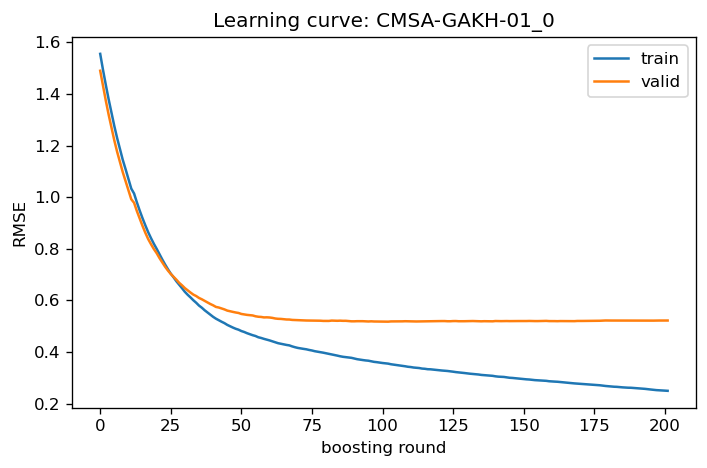

In [34]:
# ===== 07. Learning curves plotten =====
def plot_learning_curve(target):
    ev = logs[target]
    train_rmse = ev["validation_0"]["rmse"]
    valid_rmse = ev["validation_1"]["rmse"]
    plt.figure(figsize=(6,4))
    plt.plot(train_rmse, label="train")
    plt.plot(valid_rmse, label="valid")
    plt.xlabel("boosting round")
    plt.ylabel("RMSE")
    plt.title(f"Learning curve: {target}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# voorbeeld
plot_learning_curve(target_cols[0])


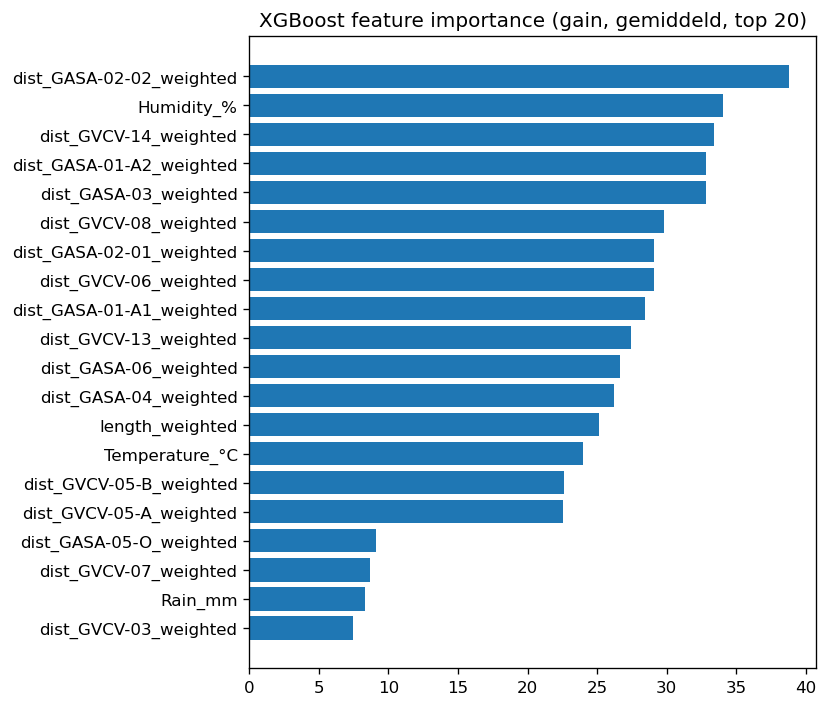

In [35]:
# ===== 08. Feature importance (gemiddeld) =====
def mean_gain_importance(models_dict, feature_names):
    gains = []
    for t, m in models_dict.items():
        booster = m.get_booster()
        fmap = booster.get_score(importance_type="gain")  # {'f0': gain, ...}
        vec = np.zeros(len(feature_names), dtype="float64")
        for k, v in fmap.items():
            idx = int(k[1:])
            if idx < len(vec):
                vec[idx] = v
        gains.append(vec)
    return np.mean(np.vstack(gains), axis=0)

imp = mean_gain_importance(models, feature_names)
order = np.argsort(imp)[::-1][:20]
plt.figure(figsize=(7,6))
plt.barh(np.array(feature_names)[order][::-1], imp[order][::-1])
plt.title("XGBoost feature importance (gain, gemiddeld, top 20)")
plt.tight_layout()
plt.show()


In [36]:
# === Features/targets afleiden (werkt zowel als je al X_train hebt, als alleen agg_df) ===
# Vereist: ofwel X_train/y_train/X_test/y_test bestaan al,
# of je hebt één DataFrame 'agg_df' + lijst 'target_cols' (zoals in je Ridge-notebook).

if "X_train" not in globals():
    assert "agg_df" in globals() and "target_cols" in globals(), "Zorg dat agg_df en target_cols bestaan"
    feature_cols = [c for c in agg_df.columns if c not in target_cols and c not in ("timestamp",)]
    X = agg_df[feature_cols].values
    y = agg_df[target_cols].values
    # zelfde split als eerder:
    assert "split_time" in globals(), "Definieer split_time zoals in Ridge-notebook"
    train_mask = agg_df["timestamp"] < split_time
    test_mask  = ~train_mask
    X_train, X_test = X[train_mask.values], X[test_mask.values]
    y_train, y_test = y[train_mask.values], y[test_mask.values]
    test_index = agg_df.loc[test_mask, "timestamp"].reset_index(drop=True)
    feature_names = feature_cols
else:
    # Als je al gesplitst hebt, zorg voor feature_names en test_index
    if "feature_names" not in globals():
        feature_names = getattr(X_train, "columns", None)
        feature_names = list(feature_names) if feature_names is not None else [f"f{i}" for i in range(X_train.shape[1])]
    if "test_index" not in globals():
        # fallback voor tijdstempels
        test_index = pd.Series(range(len(X_test)), name="timestamp")


In [39]:
# ===== 09. Opslaan modellen (optioneel) =====
import joblib, os
os.makedirs("xgb_models", exist_ok=True)
for t, m in models.items():
    joblib.dump(m, f"xgb_models/model_{t}.joblib")
print("Modellen opgeslagen in xgb_models/")


Modellen opgeslagen in xgb_models/


In [40]:
# ===== 10. Snelle sanity check =====
print("Sample predictions:", preds[:3])
print("Actuals:", y_test[:3])


Sample predictions: [[ 9.9984698e-02  5.0207447e-02  2.1710548e+00  1.9716702e+00
   3.0582595e+00  4.8115330e+00  4.0129414e+00  6.4435587e+00
   8.1032020e-01  8.1117946e-01  2.0470088e+00  3.5870535e+00
   5.6072431e+00  1.8778876e+00  5.3521293e-01  3.6492613e-01
   3.5638454e+00  3.8939354e+00  3.0417266e-01  4.1682523e-01
   3.8927931e-01  3.0007899e-01  2.0244892e-01  3.2232451e-01
   5.8114946e-01  5.5285394e-01  2.9080302e-02  8.2632720e-02
   3.3385339e-01  2.2011952e-01  8.0094852e-02  1.9965769e-01
   6.7840725e-01  1.2658441e-01  9.6797422e-03  1.2521691e+00
   1.4465919e-01  3.0417353e-01  2.9036570e-01  3.0839029e-01
   1.1442422e-01  4.7525269e-01  2.9768065e-01  3.0192998e-01
   1.6181698e-01  3.8563529e-01  0.0000000e+00  0.0000000e+00
   1.6117259e+00  1.3671073e+00  8.6459583e-01  4.6793133e-01
   1.9313936e+00  1.3562483e+00  1.9433529e+00  1.2300133e+00
   1.3877673e+00  3.7086684e-01  1.0144156e+00  1.4438560e+00
   6.0259753e-01  7.8436649e-01  5.3363204e-01  3.